### IMPORTING IMPORTANT LIBRARIES

In [1]:
from PIL import Image
import torchvision.models as models 
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn 
import torch.optim as optim
import torchvision.transforms as transforms  
from torchvision.utils import save_image

### Loading the VGG model with its pre-trained weights

In [2]:
vgg = models.vgg19(pretrained=True).features

# Freezing all VGG parameters since we're only optimizing the target image
# Setting requires_grad to False for all parameters (weights), so that no gradients are computed for the model's weights.
for param in vgg.parameters():
    param.requires_grad_(False)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:03<00:00, 156MB/s] 


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

### IMAGE PRE-PROCESSING

In [4]:
def image_loader(path):
    image=Image.open(path).convert('RGB')
    #defining the image transformation steps to be performed before feeding them to the model
    loader=transforms.Compose([transforms.Resize((512,512)), transforms.ToTensor(),transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
    #The preprocessing steps involves resizing the image and then converting it to a tensor
    image=loader(image)[:3,:,:].unsqueeze(0)
    return image

#Loading the original and the style image
original_image=image_loader('/kaggle/input/fpuppy/puppy.jpg').to(device)
style_image=image_loader('/kaggle/input/stylef/68747470733a2f2f39323835633532632d643962312d343064312d386163312d6537353633346161643932642e73332d75732d776573742d322e616d617a6f6e6177732e636f6d2f6d73743139355f736d616c6c2e6a7067.jpeg').to(device)

#Creating the generated image from the original image
generated_image=original_image.clone().requires_grad_(True).to(device)
generated_image.size()

torch.Size([1, 3, 512, 512])

In [5]:
def im_convert(tensor):
    image = tensor.cpu().clone().detach().numpy()  # Convert tensor to numpy array
    image = image.squeeze()  # Remove the batch dimension
    image = image.transpose(1, 2, 0)  # Convert from (C, H, W) to (H, W, C)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))  # De-normalize
    image = image.clip(0, 1)  # Clip to ensure valid pixel range [0, 1]

    return image

### FUNCTION TO GET FEATURES OF AN IMAGE

In [6]:
def get_features(image, model, layers=None):
    
    if layers is None:
        layers = {'0': 'conv1_1',
                  '5': 'conv2_1', 
                  '10': 'conv3_1', 
                  '19': 'conv4_1',
                  '21': 'conv4_2',  ## content representation
                  '28': 'conv5_1'}
        
    features = {}
    x = image
    # model._modules is a dictionary holding each module in the model
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
            
    return features

#### GRAM MATRIX FOR STYLE LOSS CALCULATION

In [7]:
def gram_matrix(tensor):

    _, channel, height, width = tensor.size()
    
    # reshape so we're multiplying the features for each channel -> tensor.view(channel,height * width)
    
    gram = torch.mm(tensor.view(channel,height*width),tensor.view(channel,height*width).t())
    
    return gram 

In [8]:
# Getting the content,style and target features before training 
content_features = get_features(original_image, vgg)
style_features = get_features(style_image, vgg)
target_features=get_features(generated_image,vgg)

# calculating the gram matrices for each layer of our style representation
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

In [9]:
# Let's weight each style layer differently 
# Weighting earlier layers more will result in *larger* style artifacts
style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.75,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2}

content_weight = 1  # alpha
style_weight = 1e9  # beta

# conv4_2 will be used for content loss calculation 

#### CONTENT LOSS FUNCTION

In [10]:
content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)

### TRAINING 

Total loss:  59478097920.0


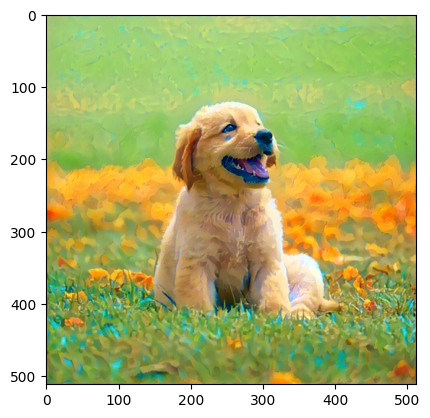

Total loss:  4036401152.0


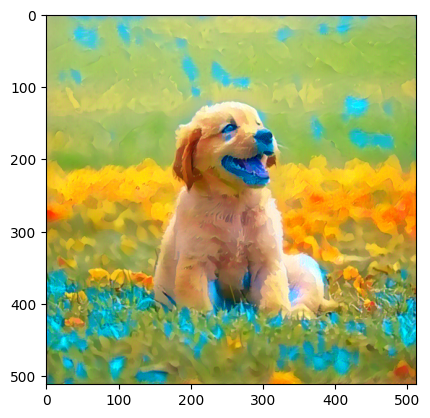

Total loss:  1701823744.0


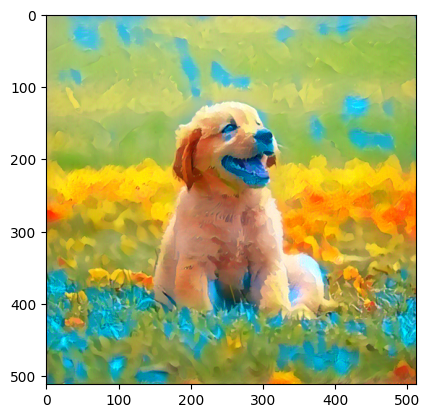

Total loss:  918297408.0


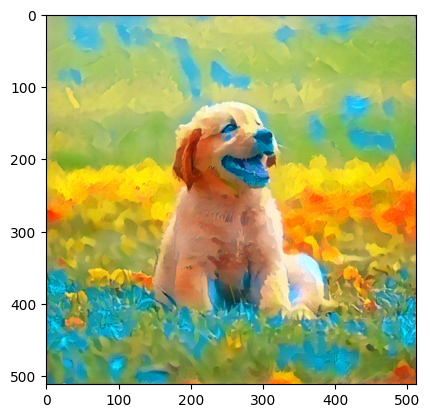

Total loss:  522440384.0


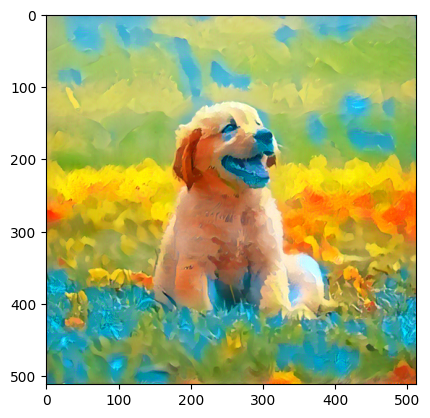

Total loss:  309438400.0


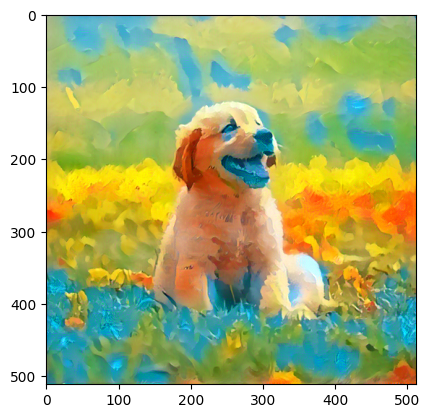

Total loss:  193338528.0


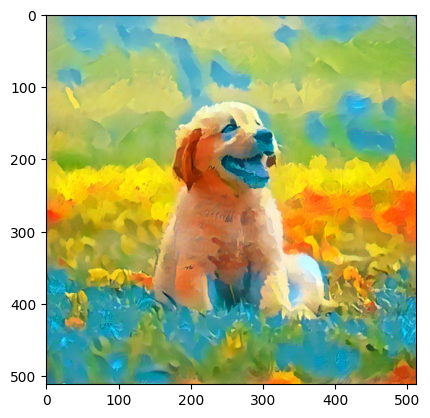

Total loss:  128087304.0


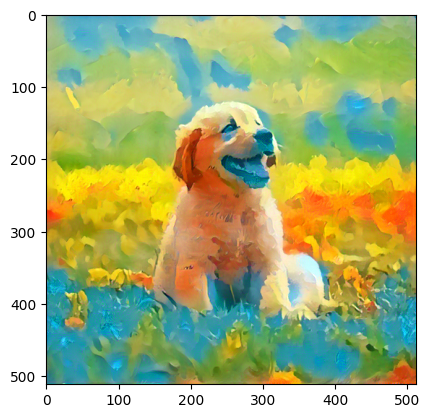

In [11]:
optimizer = optim.Adam([generated_image], lr=0.003)
epochs = 4000 

# To display the target image intermittently 
show_every = 500

for e in range (epochs):
    
    target_features = get_features(generated_image, vgg)
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)

    style_loss = 0
    # Loop to calculate style loss over each layer 
    for layer in style_weights:

        target_feature = target_features[layer]
        # Getting target image gram matrix for the particular layer
        target_gram = gram_matrix(target_feature)

        _, channel, height, width = target_feature.shape
        
        # Getting style image gram matrix for the particular layer
        style_gram = style_grams[layer]

        # the style loss for one layer, weighted appropriately
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)

        # add to the style loss
        style_loss += layer_style_loss / (channel*height*width)
        
    # Total Loss 
    total_loss = content_weight * content_loss + style_weight * style_loss
    
    #optimize the pixel values of the generated image and backpropagate the loss
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    # display intermediate images and print the loss
    if  (e+1) % show_every == 0:
        print('Total loss: ', total_loss.item())
        plt.imshow(im_convert(generated_image))
        plt.show()

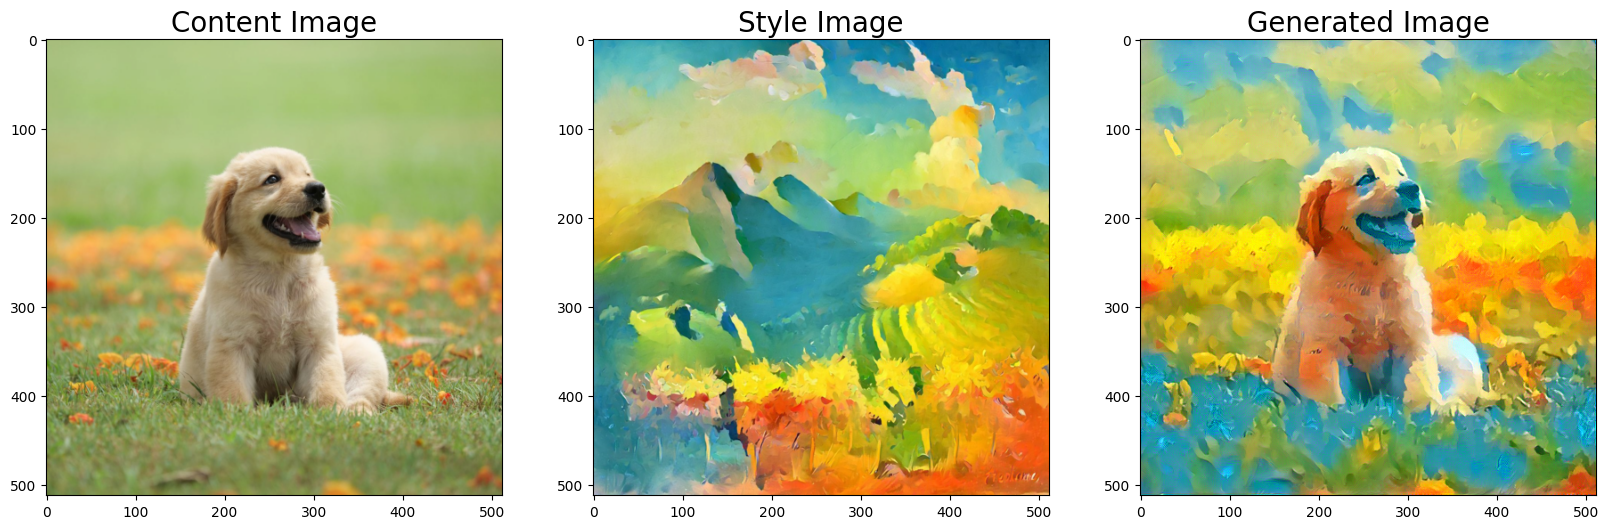

In [ ]:
# Display the images
fig, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(20, 10))
# content ,style generated images side-by-side
ax1.imshow(im_convert(original_image))
ax1.set_title("Content Image",fontsize = 20)
ax2.imshow(im_convert(style_image))
ax2.set_title("Style Image", fontsize = 20)
ax3.imshow(im_convert(generated_image))
ax3.set_title("Generated Image", fontsize = 20)
plt.show()

### SAVING THE FINAL IMAGE 

In [19]:
final_image = generated_image.clone().detach().cpu().squeeze(0)  # Removing batch dimension
final_image = im_convert(final_image)  # Converting to numpy array
# Convert to 8-bit per channel and save as an image
final_image_pil = Image.fromarray((final_image * 255).astype(np.uint8))
final_image_pil.save('/kaggle/working/final_generated_image.png')